# Small usage demo on Norman dataset

## Prepare data

In [1]:
# Get Norman et al. (https://doi.org/10.1126/science.aax4438) dataset from
# scPerturb (http://projects.sanderlab.org/scperturb/, https://zenodo.org/records/7041849)

#!wget https://zenodo.org/records/7041849/files/NormanWeissman2019_filtered.h5ad?download=1
#!mv NormanWeissman2019_filtered.h5ad?download=1 NormanWeissman2019_filtered.h5ad

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc

adata = sc.read_h5ad('NormanWeissman2019_filtered.h5ad')

In [4]:
# Just for demo purposes: Reduce number of genes only to genes, on which we have observed perturbations
# (One could also add highly variable genes or genes according to some other selection criterion)

all_perturbations = adata.obs.perturbation.unique()
target_genes = [gene for gene in all_perturbations if ( (not '_' in gene) and gene != 'control')]

print(target_genes)

# Reduce the set of target genes to 20 for faster debugging
# FIXME: Remove this line
#target_genes = target_genes[:20]

['ARID1A', 'BCORL1', 'FOSB', 'OSR2', 'TP73', 'HES7', 'UBASH3B', 'MAP2K6', 'BCL2L11', 'UBASH3A', 'LHX1', 'FOXA3', 'CDKN1A', 'HOXB9', 'CSRNP1', 'ISL2', 'CDKN1C', 'MAP7D1', 'CDKN1B', 'PTPN1', 'ZBTB25', 'SET', 'SLC4A1', 'STIL', 'CNN1', 'SAMD1', 'MAML2', 'BAK1', 'IER5L', 'DLX2', 'RREB1', 'CELF2', 'HNF4A', 'ETS2', 'COL1A1', 'SLC6A9', 'PTPN9', 'TBX2', 'PRTG', 'KLF1', 'SPI1', 'RUNX1T1', 'ZC3HAV1', 'CNNM4', 'PLK4', 'TBX3', 'CLDN6', 'CBFA2T3', 'IRF1', 'BPGM', 'KIF18B', 'CEBPE', 'TMSB4X', 'IGDCC3', 'ELMSAN1', 'CITED1', 'FOXA1', 'TSC22D1', 'C3orf72', 'HOXA13', 'TGFBR2', 'ZNF318', 'MAPK1', 'C19orf26', 'PTPN12', 'SNAI1', 'MAP4K3', 'MAP2K3', 'GLB1L2', 'KIAA1804', 'KIF2C', 'MEIS1', 'FOXF1', 'MAP4K5', 'ARRDC3', 'SLC38A2', 'COL2A1', 'MIDN', 'CEBPB', 'CBL', 'PRDM1', 'IKZF3', 'KMT2A', 'S1PR2', 'FOXL2', 'ATL1', 'CKS1B', 'RHOXF2', 'PTPN13', 'EGR1', 'HOXC13', 'HK2', 'CEBPA', 'AHR', 'LYL1', 'FEV', 'ZBTB1', 'DUSP9', 'NCL', 'SGK1', 'NIT1', 'ZBTB10', 'POU3F2', 'FOXO4', 'JUN']


In [5]:
n_highly_variable = 500 # SHOULD BE 2500!

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes = n_highly_variable)

In [6]:
# Combine highly-variable and perturbed genes
# NOTE: We would expect here to be a substantial overlap
highly_variable_genes = adata.var.index[adata.var.highly_variable]
genes = set( list(highly_variable_genes) + list(target_genes) )

print('len(highly_variable_genes):', len(highly_variable_genes))
print('len(target_genes):', len(target_genes))
print('len(genes):', len(genes))

len(highly_variable_genes): 500
len(target_genes): 105
len(genes): 582


In [7]:
adata = adata[:,adata.var.index.isin(genes)]
adata

View of AnnData object with n_obs × n_vars = 111445 × 579
    obs: 'guide_id', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo'
    var: 'ensemble_id', 'ncounts', 'ncells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [8]:
# Select cells, for which the perturbed genes were also observed / sequenced

conditions = adata.obs['perturbation'].unique()

ok_conditions = set()

for cond in conditions:
    
    if cond == 'control' or (cond in adata.var.index) or ('_' in cond and cond.split('_')[0] in adata.var.index and cond.split('_')[1] in adata.var.index):
        ok_conditions.add(cond)
        
adata = adata[adata.obs.perturbation.isin(ok_conditions)]
adata

View of AnnData object with n_obs × n_vars = 109647 × 579
    obs: 'guide_id', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo'
    var: 'ensemble_id', 'ncounts', 'ncells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

<Axes: >

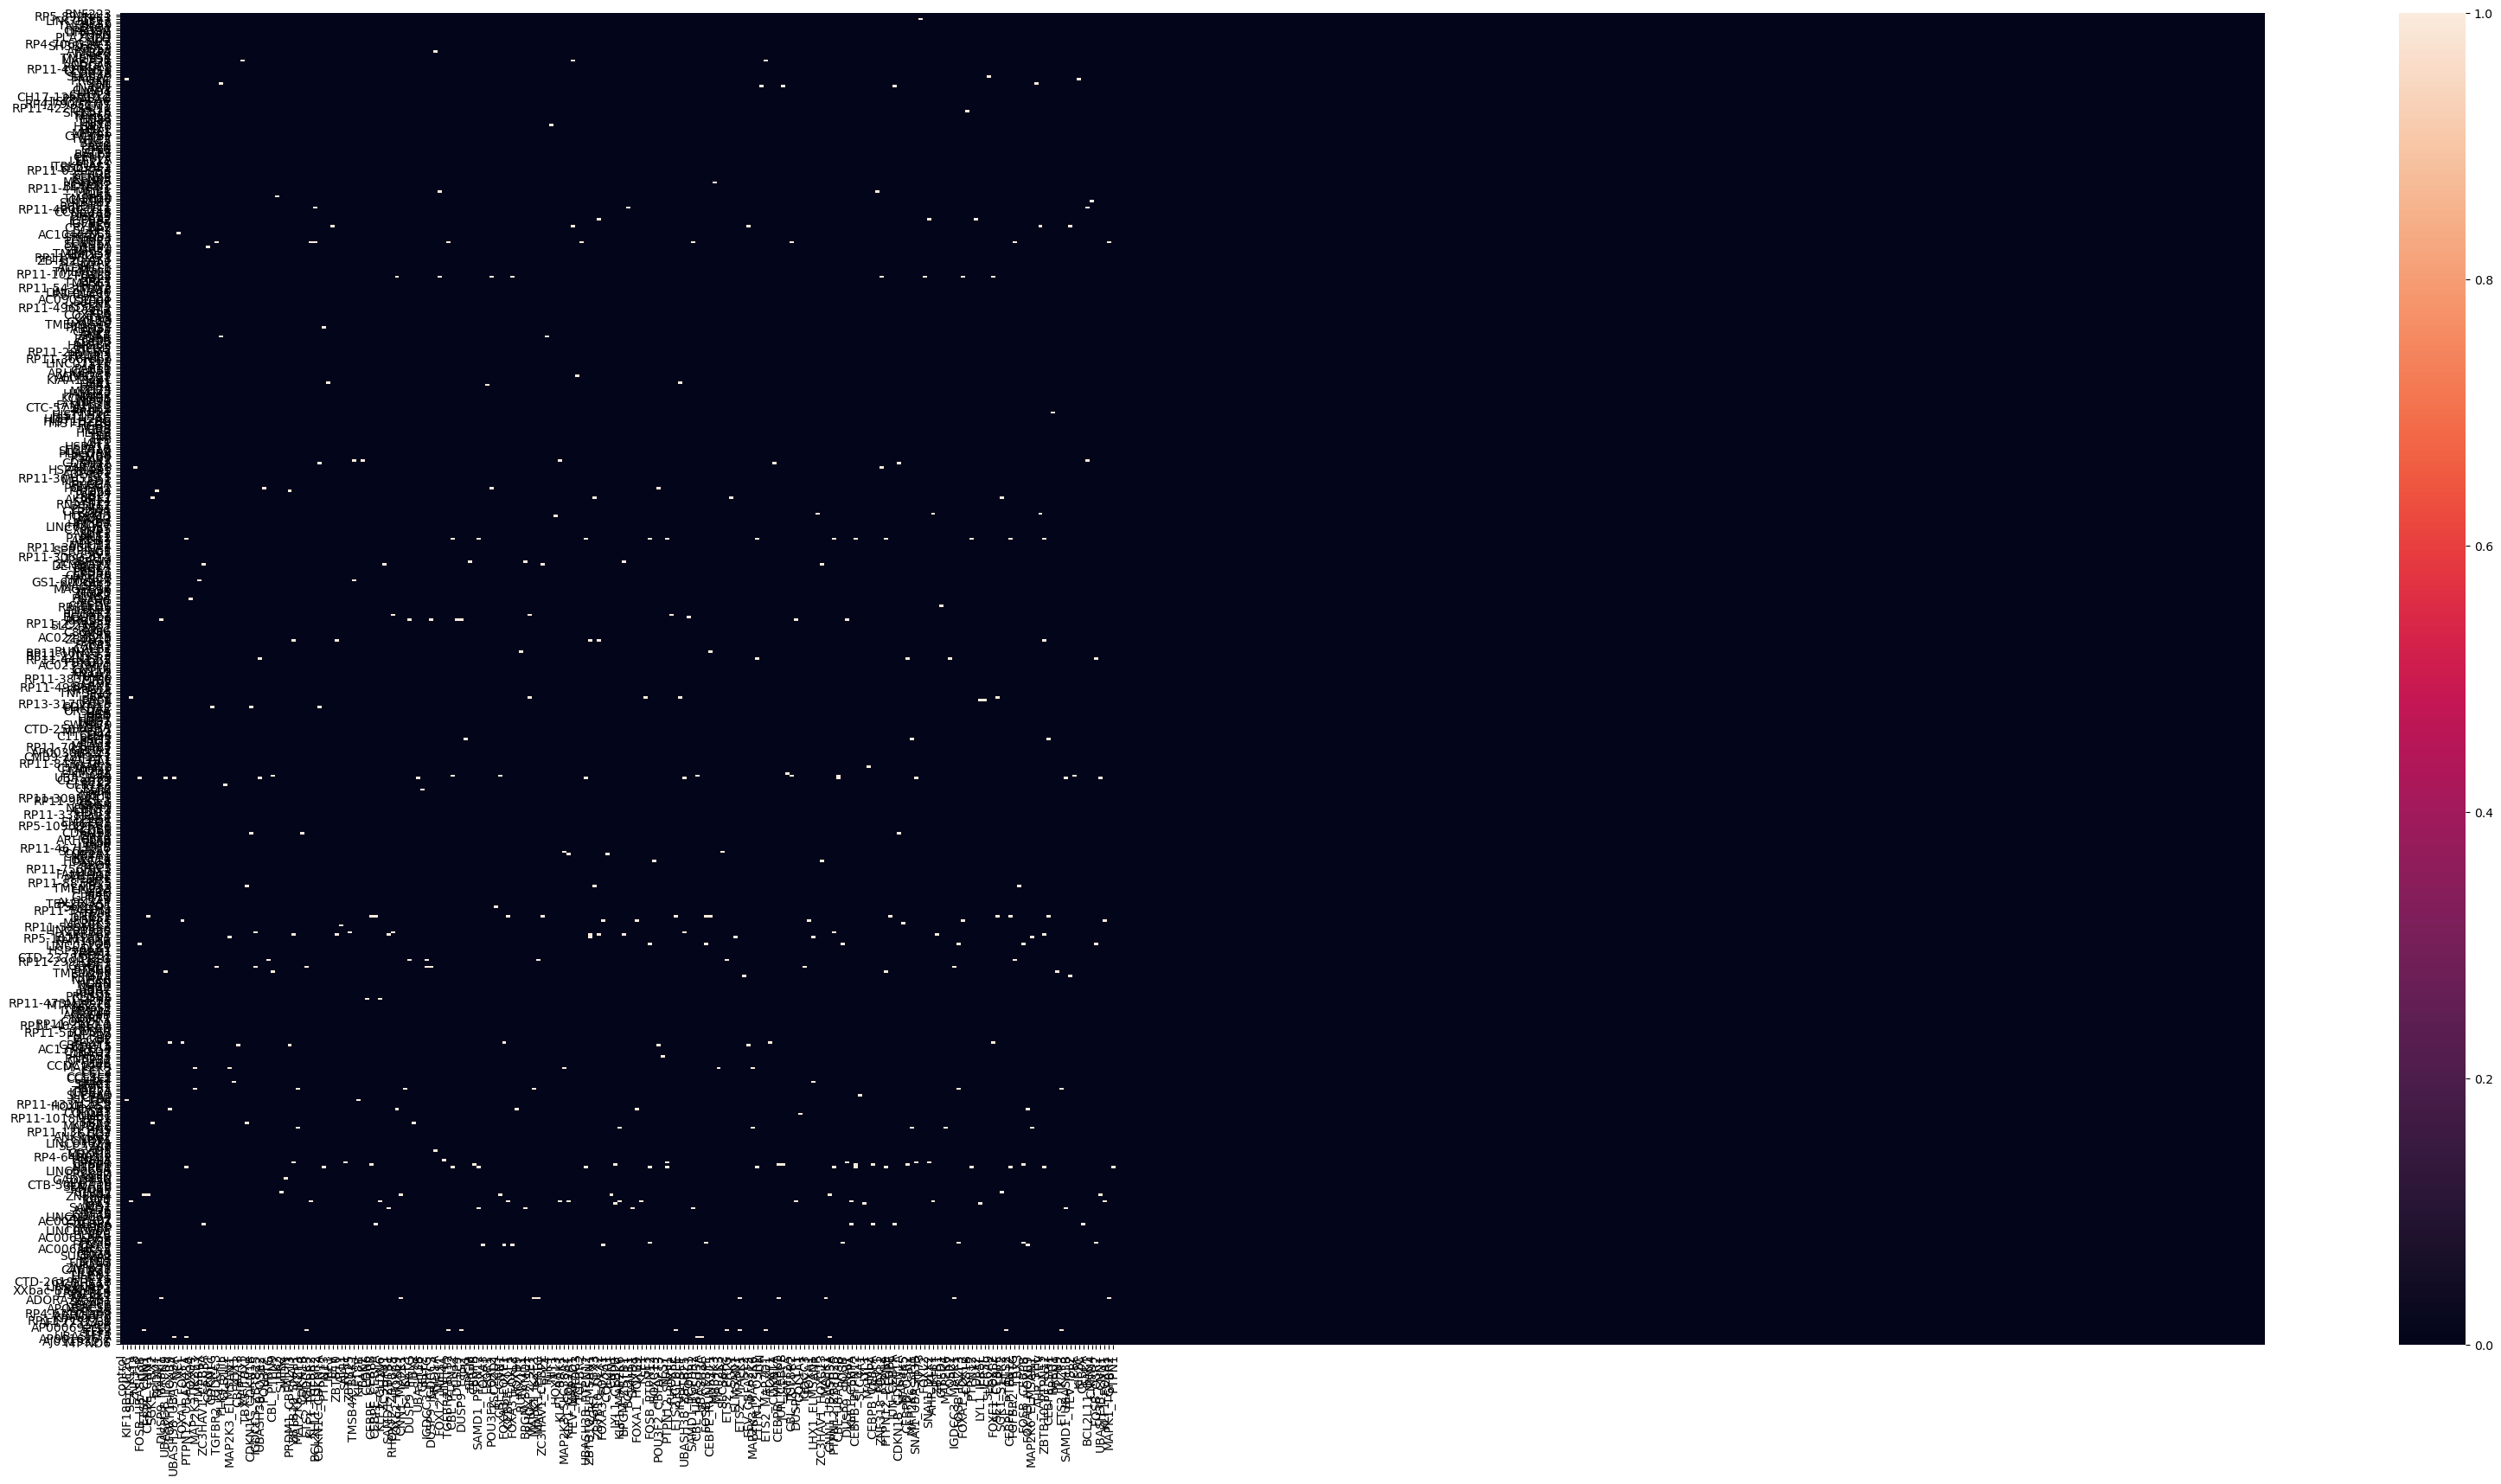

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch

ok_conditions = list(ok_conditions)

n_conditions = len(ok_conditions)
n_genes = len(adata.var.index)

cond_map = dict()

# We just append "unperturbed" conditions (zero columns in gt_interv are zero)
# to test the scaling behavior

# Currently, the model fits a multivariate normal for each condition and keeps all of these parameters in memory
# To scale to more conditions, one could think of writing the parameters to disk and only load and update the parameters corresponding
# to conditions present in the current training batch. This might require some re-engineering of the model class, though.

min_test_conditions = 500 # SHOULD BE: 2500

n_conditions = max(n_conditions, min_test_conditions)

gt_interv = torch.tensor(np.zeros( (n_genes, n_conditions) )).long()

for i, cond in enumerate(ok_conditions):
    
    cond_map[cond] = i
    
    for j, gene in enumerate(adata.var.index):
        
        if gene in cond:
            gt_interv[j, i] = 1

# Let us have a look, how such a matrix looks like :)            
plt.figure(figsize = (40,20))            
sns.heatmap(gt_interv, yticklabels = adata.var.index, xticklabels = ok_conditions)

In [10]:
# Create samples matrix

samples = torch.tensor(np.asarray(adata.X.todense())).float()
samples.shape

torch.Size([109647, 579])

In [11]:
# Create regime vector

regimes = torch.tensor(np.asarray([cond_map[pert] for pert in adata.obs.perturbation])).long()
regimes.shape

torch.Size([109647])

In [12]:
# Now just create a train-validation-test split

# Use single-gene perturbations for training and validation and put 

train_gene_ko = [str(x) for x in range(n_genes)]

# Use double-gene perturbations for testing

# Regimes for training (and validation/hyperparameter tuning)
train_regimes = list()

# Regimes with dual perturbations to hold out for testing
test_regimes = list()

for c in range(n_conditions):
    if gt_interv[:,c].sum() > 1.5:
        test_regimes.append(c)
    else:
        train_regimes.append(c)

In [13]:
from bicycle.utils.data import create_loaders_norman

# Generate data loaders

validation_size = 0.2
batch_size = 32
SEED = 0

train_loader, validation_loader, test_loader = create_loaders_norman(
    samples,
    regimes,
    validation_size,
    batch_size,
    SEED,
    train_regimes,
    test_regimes
)

covariates = None

print("Training data:")
print(f"- Number of training samples: {len(train_loader.dataset)}")
print("Training regimes:", train_regimes)
if validation_size > 0:
    print(f"- Number of validation samples: {len(validation_loader.dataset)}")
if len(test_regimes) > 0:
    print(f"- Number of test samples: {len(test_loader.dataset)}")
    print("Test regimes:", test_regimes)


Training data:
- Number of training samples: 109647
Training regimes: [0, 3, 8, 13, 16, 18, 20, 21, 24, 26, 27, 28, 33, 34, 36, 37, 38, 42, 48, 49, 51, 52, 53, 55, 56, 57, 61, 66, 68, 69, 70, 75, 78, 80, 81, 82, 84, 85, 87, 92, 93, 99, 100, 101, 106, 107, 113, 114, 118, 119, 121, 122, 124, 126, 128, 132, 135, 138, 139, 140, 142, 143, 145, 149, 151, 152, 155, 158, 159, 160, 162, 164, 172, 173, 174, 176, 179, 182, 186, 187, 190, 191, 192, 193, 197, 199, 201, 202, 206, 209, 213, 217, 218, 222, 223, 224, 226, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328,

In [14]:
import warnings

warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", category=FutureWarning)

import time
import os
from pathlib import Path
from os import environ
import pytorch_lightning as pl
import torch
from bicycle.dictlogger import DictLogger
from bicycle.model import BICYCLE
from bicycle.utils.data import (
    create_loaders,
    get_diagonal_mask,
)
from bicycle.utils.general import get_full_name
from bicycle.utils.plotting import plot_training_results
from pytorch_lightning.callbacks import RichProgressBar, StochasticWeightAveraging
from bicycle.callbacks import ModelCheckpoint, GenerateCallback, MyLoggerCallback, CustomModelCheckpoint
import numpy as np
import yaml
from pytorch_lightning.tuner.tuning import Tuner

# This bounds the rank of the covariance matrices, which are fit for each perturbation condition,
# to 5, as well as the rank of the beta parameter matrix
n_factors = 5

# The Norman data have CRISPRa interventions - use dCas9
intervention_type_inference = "dCas9"

SEED = 1
pl.seed_everything(SEED)
torch.set_float32_matmul_precision("high")
device = torch.device("cpu")

user_dir = "."

MODEL_PATH = Path(os.path.join(user_dir, "models"))
PLOT_PATH = Path(os.path.join(user_dir, "plots"))
MODEL_PATH.mkdir(parents=True, exist_ok=True)
PLOT_PATH.mkdir(parents=True, exist_ok=True)

#
# Settings
#

# TRAINING
lr = 1e-3
USE_INITS = False

# Using the encoder is crucial to scale to hundreds of thousands of cells ore more - but it is not tested, yet.
use_encoder = True
n_epochs = 51000
early_stopping = False
early_stopping_patience = 500
early_stopping_min_delta = 0.01
# Maybe this helps to stop the loss from growing late during training (see current version
# of Plot_Diagnostics.ipynb)
optimizer = "rmsprop" #"rmsprop" #"adam"
optimizer_kwargs = {}
#    "betas": [0.5,0.9] # Faster decay for estimates of gradient and gradient squared
#}
gradient_clip_val = 1e-3
GPU_DEVICE = 0
plot_epoch_callback = 500
validation_size = 0.2
lyapunov_penalty = True
swa = 250
n_epochs_pretrain_latents = 1000#10000

# MODEL
x_distribution = "Multinomial"
x_distribution_kwargs = {}
model_T = 1.0
learn_T = False
use_latents = True
perfect_interventions = True
rank_w_cov_factor = n_genes # Fitting full covariance matrices for multivariate normals

# RESULTS
name_prefix = f"2TEST_CHECKPOINTS_Norman_Demo_optim{optimizer}_b1_0.5_b2_0.9_pretrain_epochs{n_epochs_pretrain_latents}_GRAD-CLIP_INF:{intervention_type_inference}-slow_lr_{use_encoder}_{batch_size}_{lyapunov_penalty}"
SAVE_PLOT = True
CHECKPOINTING = True
VERBOSE_CHECKPOINTING = True
OVERWRITE = True
# REST
n_samples_total = len(adata)
check_val_every_n_epoch = 1
log_every_n_steps = 1

# Create Mask
mask = get_diagonal_mask(n_genes, device)

if n_factors > 0:
    mask = None

Global seed set to 1


In [15]:
if USE_INITS:
    init_tensors = compute_inits(train_loader.dataset, rank_w_cov_factor, n_contexts)

device = torch.device(f"cuda:{GPU_DEVICE}")
gt_interv = gt_interv.to(device)
n_genes = samples.shape[1]

if covariates is not None and correct_covariates:
    covariates = covariates.to(device)

for scale_kl in [1.0]:  # 1
    for scale_l1 in [1.0]:
        for scale_spectral in [0.0]: # 1.0
            for scale_lyapunov in [0.1]: # 0.1
                file_dir = get_full_name(
                    name_prefix,
                    len(test_regimes),
                    SEED,
                    lr,
                    n_genes,
                    scale_l1,
                    scale_kl,
                    scale_spectral,
                    scale_lyapunov,
                    gradient_clip_val,
                    swa,
                )

                # If final plot or final model exists: do not overwrite by default
                print("Checking Model and Plot files...")
                final_file_name = os.path.join(MODEL_PATH, file_dir, "last.ckpt")
                final_plot_name = os.path.join(PLOT_PATH, file_dir, "last.png")
                
                # Save simulated data for inspection and debugging
                final_data_path = os.path.join(PLOT_PATH, file_dir)
                
                if os.path.isdir(final_data_path):
                    print(final_data_path, "exists")
                else:
                    print("Creating", final_data_path)
                    os.mkdir(final_data_path)
                
                np.save(os.path.join(final_data_path,'check_samples.npy'), samples.detach().cpu().numpy())
                np.save(os.path.join(final_data_path,'check_regimes.npy'), regimes.detach().cpu().numpy())
                np.save(os.path.join(final_data_path,'check_gt_interv.npy'), gt_interv.detach().cpu().numpy())
                
                labels = list(adata.var.index)
                
                np.save(os.path.join(final_data_path,'labels.npy'), labels, allow_pickle=True)
                
                if (Path(final_file_name).exists() & SAVE_PLOT & ~OVERWRITE) | (
                    Path(final_plot_name).exists() & CHECKPOINTING & ~OVERWRITE
                ):
                    print("- Files already exists, skipping...")
                    continue
                else:
                    print("- Not all files exist, fitting model...")
                    print("  - Deleting dirs")
                    # Delete directories of files
                    if Path(final_file_name).exists():
                        print(f"  - Deleting {final_file_name}")
                        # Delete all files in os.path.join(MODEL_PATH, file_name)
                        for f in os.listdir(os.path.join(MODEL_PATH, file_dir)):
                            os.remove(os.path.join(MODEL_PATH, file_dir, f))
                    if Path(final_plot_name).exists():
                        print(f"  - Deleting {final_plot_name}")
                        for f in os.listdir(os.path.join(PLOT_PATH, file_dir)):
                            os.remove(os.path.join(PLOT_PATH, file_dir, f))

                    print("  - Creating dirs")
                    # Create directories
                    Path(os.path.join(MODEL_PATH, file_dir)).mkdir(parents=True, exist_ok=True)
                    Path(os.path.join(PLOT_PATH, file_dir)).mkdir(parents=True, exist_ok=True)

                model = BICYCLE(
                    lr,
                    gt_interv,
                    n_genes,
                    n_samples=n_samples_total,
                    lyapunov_penalty=lyapunov_penalty,
                    perfect_interventions=perfect_interventions,
                    rank_w_cov_factor=rank_w_cov_factor,
                    init_tensors=init_tensors if USE_INITS else None,
                    optimizer=optimizer,
                    optimizer_kwargs = optimizer_kwargs,
                    device=device,
                    scale_l1=scale_l1,
                    scale_lyapunov=scale_lyapunov,
                    scale_spectral=scale_spectral,
                    scale_kl=scale_kl,
                    early_stopping=early_stopping,
                    early_stopping_min_delta=early_stopping_min_delta,
                    early_stopping_patience=early_stopping_patience,
                    early_stopping_p_mode=True,
                    x_distribution=x_distribution,
                    x_distribution_kwargs=x_distribution_kwargs,
                    mask=mask,
                    use_encoder=use_encoder,
                    train_gene_ko=train_regimes,
                    test_gene_ko=test_regimes,
                    use_latents=use_latents,
                    covariates=covariates,
                    n_factors = n_factors,
                    intervention_type = intervention_type_inference,
                    T = model_T,
                    learn_T = learn_T
                )
                model.to(device)

                dlogger = DictLogger()
                loggers = [dlogger]

                callbacks = [
                    RichProgressBar(refresh_rate=1),
                    GenerateCallback(
                        final_plot_name, plot_epoch_callback=plot_epoch_callback,labels=labels
                    ),
                ]
                if swa > 0:
                    callbacks.append(StochasticWeightAveraging(0.01, swa_epoch_start=swa))
                if CHECKPOINTING:
                    Path(os.path.join(MODEL_PATH, file_dir)).mkdir(parents=True, exist_ok=True)
                    
                    print('Checkpointing to:',MODEL_PATH)
                    
                    callbacks.append(
                        CustomModelCheckpoint(
                            dirpath=os.path.join(MODEL_PATH, file_dir),
                            filename="{epoch}",
                            save_last=True,
                            save_top_k=1,
                            verbose=VERBOSE_CHECKPOINTING,
                            monitor="valid_loss",
                            mode="min",
                            save_weights_only=True,
                            start_after=1000,
                            save_on_train_epoch_end=True,
                            every_n_epochs=500,
                        )
                    )
                    callbacks.append(MyLoggerCallback(dirpath=os.path.join(MODEL_PATH, file_dir)))

                trainer = pl.Trainer(
                    max_epochs=n_epochs,
                    accelerator="gpu",  # if str(device).startswith("cuda") else "cpu",
                    logger=loggers,
                    log_every_n_steps=log_every_n_steps,
                    enable_model_summary=True,
                    enable_progress_bar=True,
                    enable_checkpointing=CHECKPOINTING,
                    check_val_every_n_epoch=check_val_every_n_epoch,
                    devices=[GPU_DEVICE],  # if str(device).startswith("cuda") else 1,
                    num_sanity_val_steps=0,
                    callbacks=callbacks,
                    gradient_clip_val=gradient_clip_val,
                    default_root_dir=str(MODEL_PATH),
                    gradient_clip_algorithm="value",
                    deterministic=False, #"warn",
                )
                
                '''print('Optimizing learning rates')
                
                tuner = Tuner(trainer)

                # Run learning rate finder
                lr_finder = tuner.lr_find(model)

                # Results can be found in
                print(lr_finder.results)

                # Plot with
                fig = lr_finder.plot(suggest=True)
                fig.save('lr_finder.png')

                # Pick point based on plot, or get suggestion
                new_lr = lr_finder.suggestion()
                
                print('Using learning rate of:',new_lr)

                # update hparams of the model
                model.hparams.lr = new_lr'''

                
                if use_latents and n_epochs_pretrain_latents > 0:
                    
                    pretrain_callbacks = [
                        RichProgressBar(refresh_rate=1),
                        GenerateCallback(
                            str(Path(final_plot_name).with_suffix("")) + '_pretrain', plot_epoch_callback=plot_epoch_callback,labels=labels
                        ),                    
                    ]
                    
                    if swa > 0:
                        pretrain_callbacks.append(StochasticWeightAveraging(0.01, swa_epoch_start=swa))
    
                    pretrain_callbacks.append(MyLoggerCallback(dirpath=os.path.join(MODEL_PATH, file_dir)))
                    
                    pretrainer = pl.Trainer(
                        max_epochs=n_epochs_pretrain_latents,
                        accelerator="gpu",  # if str(device).startswith("cuda") else "cpu",
                        logger=loggers,
                        log_every_n_steps=log_every_n_steps,
                        enable_model_summary=True,
                        enable_progress_bar=True,
                        enable_checkpointing=CHECKPOINTING,
                        check_val_every_n_epoch=check_val_every_n_epoch,
                        devices=[GPU_DEVICE],  # if str(device).startswith("cuda") else 1,
                        num_sanity_val_steps=0,
                        callbacks=pretrain_callbacks,
                        gradient_clip_val=gradient_clip_val,
                        default_root_dir=str(MODEL_PATH),
                        gradient_clip_algorithm="value",
                        deterministic=False, #"warn",
                    )
                    
                    print('PRETRAINING LATENTS!')
                    start_time = time.time()
                    model.train_only_likelihood = True
                    # assert False
                    pretrainer.fit(model, train_loader, validation_loader)
                    end_time = time.time()
                    model.train_only_likelihood = False
                
                # try:
                start_time = time.time()
                # assert False
                trainer.fit(model, train_loader, validation_loader)
                end_time = time.time()
                print(f"Training took {end_time - start_time:.2f} seconds")

                plot_training_results(
                    trainer,
                    model,
                    model.beta.detach().cpu().numpy(),
                    beta,
                    scale_l1,
                    scale_kl,
                    scale_spectral,
                    scale_lyapunov,
                    final_plot_name,
                    callback=False,
                )
                # except Exception as e:
                #     # Write Exception to file
                #     report_path = os.path.join(MODEL_PATH, file_dir, "report.yaml")
                #     # Write yaml
                #     with open(report_path, "w") as outfile:
                #         yaml.dump({"exception": str(e)}, outfile, default_flow_style=False)

Checking Model and Plot files...
plots/2TEST_CHECKPOINTS_Norman_Demo_optimrmsprop_b1_0.5_b2_0.9_pretrain_epochs1000_GRAD-CLIP_INF:dCas9-slow_lr_True_32_True_134_1_0.001_579_1.0_1.0_0.0_0.1_0.001_250 exists
- Not all files exist, fitting model...
  - Deleting dirs
  - Creating dirs
Initializing gene2factor and factor2gene matrices!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Checkpointing to: models


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/g/stegle/ueltzhoe/env_bicycle_main/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory models/DictLogger/0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


PRETRAINING LATENTS!
Using optimizer_kwargs: {}


┏━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type     ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder │ Encoder  │  1.2 M │
│ 1 │ pos     │ Softplus │      0 │
└───┴─────────┴──────────┴────────┘

Trainable params: 169 M                                                                                            
Non-trainable params: 5.8 K                                                                                        
Total params: 169 M                                                                                                
Total estimated model params size (MB): 676

Output()

/g/stegle/ueltzhoe/env_bicycle_main/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning:
Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


KeyboardInterrupt



# Plots, logs and beta-estimates will be written to the ./plots/RUN_NAME subfolder

# Plot loss curves and examine GRN matrix

These log files used in the following cells are written every `plot_epoch_callback` during training, so they can also be used to monitor convergende during training.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import os

base_path = "/g/stegle"

In [ ]:
import gseapy as gp

In [ ]:
def plot_vars_from_df(df, variables):
    plt.figure()

    for variable in variables:
        df_plot = df[df["variable"] == variable]
        plt.plot( df_plot["epoch"], df_plot["value"], label = variable)

    plt.legend()    
    plt.show()

In [ ]:
log_path = "ueltzhoe/bicycle_main/bicycle/notebooks/experiments/norman/plots/Norman_Demo_optimadam_b1_0.5_b2_0.9_pretrain_epochs1000_GRAD-CLIP_INF:dCas9-slow_lr_False_10240_True_8_1_0.001_20_1.0_1.0_0.0_0.1_0.001_250/last_log_train.csv"
df = pd.read_csv(os.path.join(base_path,log_path))

In [ ]:
df.variable.unique()

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

variables = [
    "train_l1",
    "train_nll_train",
    "train_kl_train",
    "train_loss"
]

for var in variables:
    plot_vars_from_df(df, [var])

In [ ]:
import numpy as np

gene_list_path = 'ueltzhoe/bicycle_main/bicycle/notebooks/experiments/norman/plots/Norman_Demo_optimadam_b1_0.5_b2_0.9_pretrain_epochs1000_GRAD-CLIP_INF:dCas9-slow_lr_False_10240_True_8_1_0.001_20_1.0_1.0_0.0_0.1_0.001_250/labels.npy'

gene_list = np.load(os.path.join(base_path,gene_list_path), allow_pickle=True)
gene_list

In [ ]:
import numpy as np

estimated_path = "ueltzhoe/bicycle_main/bicycle/notebooks/experiments/norman/plots/Norman_Demo_optimadam_b1_0.5_b2_0.9_pretrain_epochs1000_GRAD-CLIP_INF:dCas9-slow_lr_False_10240_True_8_1_0.001_20_1.0_1.0_0.0_0.1_0.001_250/last_estimated_beta_epoch6500.npy"
estimated_beta = np.load(os.path.join(base_path,estimated_path))

# Apply threshold (optional)
#estimated_beta = np.abs(estimated_beta) > 5.0

In [ ]:
%matplotlib inline

import seaborn as sns

plt.figure()
plt.title("Estimated Whole Network")
sns.heatmap(estimated_beta[:,:],
            annot = False,
            annot_kws={"fontsize": 7},
            center=0,
            cmap="vlag",
            vmin = -1.0,
            vmax = 1.0
           )
plt.show()

plt.close()

plt.figure()
plt.title('Distribution of edge strengths')
plt.hist(estimated_beta.flatten(), range = [-1.0,1.0], bins = 100)
plt.show()

In [ ]:
# REMEMBER: \beta_ij is the LINEAR EFFECT OF THE EXPRESSION OF GENE i 
#           on the TRANSCRIPTION RATE OF GENE j

plt.figure()
plt.title("Showing x[:,10] = 1 and x[90,:] = 1")
x = np.zeros((100,100))
x[:,10] = 1
x[90,:] = 1
sns.heatmap(x,
            annot = False,
            annot_kws={"fontsize": 7},
            center=0,
            cmap="vlag",
            vmin = -1.0,
            vmax = 1.0
           )
plt.show()

plt.close()

In [ ]:
# REMEMBER: \beta_ij is the LINEAR EFFECT OF THE EXPRESSION OF GENE i 
#           on the TRANSCRIPTION RATE OF GENE j

print('TOTAL SUM:',np.abs(estimated_beta).sum())

parents = np.abs(estimated_beta).sum(axis = 0)
genes_sorted_by_parents = [{gene_list[i]: parents[i]} for i in np.argsort(-np.abs(parents)).squeeze().astype(int).tolist()]

children = np.abs(estimated_beta).sum(axis = 1)
genes_sorted_by_children = [{gene_list[i]: children[i]} for i in np.argsort(-np.abs(children)).squeeze().astype(int).tolist()]

degree = np.abs(estimated_beta).sum(axis = 1) + np.abs(estimated_beta).sum(axis = 0)
genes_sorted_by_degree = [{gene_list[i]: degree[i]} for i in np.argsort(-np.abs(degree)).squeeze().astype(int).tolist()]

In [ ]:
genes_sorted_by_degree[:20]

In [ ]:
genes_sorted_by_parents[:20]

In [ ]:
genes_sorted_by_children[:20]

In [ ]:
sum_thresh = 1.5
category = parents # parents or children

nodes_list = [gene_list[i] for i,p in enumerate(parents) if abs(p) > sum_thresh ]               
             

print(len(nodes_list))

In [ ]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list=nodes_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],#'MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

enr.results.groupby('Gene_set').head(20)

# Load model checkpoint and perform evaluation

In [ ]:
filename = "/g/stegle/ueltzhoe/bicycle_main/bicycle/notebooks/experiments/norman/models/DictLogger/0/checkpoints/epoch=624-step=1875.ckpt"

eval_model = BICYCLE.load_from_checkpoint(checkpoint_path=filename, map_location=device, strict=True)

# Predicts means for conditions, for which only the alpha_p and sigma_p parameters, modeling the MARGINAL DISTRIBUTION 
# of the direct perturbation target genes were optimized.

# TODO: Implement additional option to either specify or infer/predict these marginal distributions to predict unseen
# activation/knock-down/knock-out interventions from similar training interventions on different target genes.

eval_model.predict_means(regimes = [0,1])